#### Where do healthy people live in the US?
#### Problem Statement
    Understanding key factors correlating with positive health outcomes is important for driving public health policy. Here, we examine factors such as income, access to food (both ”healthy” and ”unhealthy” options), and access to recreational space and their relationship with health indicators such as diabetes rate, heart disease mortality, and life expectancy on the county level. We will also look for signs of racial/ethnic bias in access to health while controlling for potential differences in income. Our findings could function as an initial step towards government funding for public recreational areas, local farmers and markets, and/or grocery stores in counties lacking access.
#### Data Sources: 
    USDA ”Food Environment Atlas”.

In [2]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

#### Load Data..
##### Combine all sheets from USDA ”Food Environment Atlas”

In [4]:
excel_data = pd.ExcelFile('FoodEnvironmentAtlas.xlsx')
relevant_sheets = ['ACCESS', 'INSECURITY', 'LOCAL', 'STORES', 'RESTAURANTS', 'ASSISTANCE', 'HEALTH', 'SOCIOECONOMIC']
data_dict = {sheet: excel_data.parse(sheet) for sheet in relevant_sheets}
combined_dataset = data_dict[relevant_sheets[0]].copy()

for sheet in relevant_sheets[1:]:
    combined_dataset = pd.merge(
        combined_dataset,
        data_dict[sheet],
        on=['FIPS', 'State', 'County'],
        how='inner'
    )
print("Combined Dataset Shape:", combined_dataset.shape)
print("Combined Dataset Columns:", combined_dataset.columns)

Combined Dataset Shape: (3143, 279)
Combined Dataset Columns: Index(['FIPS', 'State', 'County', 'LACCESS_POP10', 'LACCESS_POP15',
       'PCH_LACCESS_POP_10_15', 'PCT_LACCESS_POP10', 'PCT_LACCESS_POP15',
       'LACCESS_LOWI10', 'LACCESS_LOWI15',
       ...
       'PCT_NHPI10', 'PCT_65OLDER10', 'PCT_18YOUNGER10', 'MEDHHINC15',
       'POVRATE15', 'PERPOV10', 'CHILDPOVRATE15', 'PERCHLDPOV10', 'METRO13',
       'POPLOSS10'],
      dtype='object', length=279)


In [5]:
combined_dataset = combined_dataset[['FIPS', 'State', 'County', 'LACCESS_POP15', 'PCH_LACCESS_POP_10_15','PCT_LACCESS_POP15','LACCESS_LOWI15','PCH_LACCESS_LOWI_10_15','PCT_LACCESS_LOWI15',
'LACCESS_CHILD15','PCT_LACCESS_CHILD15','LACCESS_SENIORS15','PCH_LACCESS_SENIORS_10_15','PCT_LACCESS_SENIORS15',
'GROC16','PCH_GROC_11_16','SUPERC16','PCH_SUPERC_11_16','CONVS16','PCH_CONVS_11_16','SPECS16','PCH_SPECS_11_16','SNAPS17','PCH_SNAPS_12_17',
'WICS16','PCH_WICS_11_16','FFR16','PCH_FFR_11_16','FSR16','PCH_FSR_11_16','REDEMP_SNAPS17','PCH_REDEMP_SNAPS_12_17','PC_SNAPBEN17',
'PCH_PC_SNAPBEN_12_17','PCT_NSLP17','PCH_NSLP_12_17','PCT_FREE_LUNCH15','PCT_REDUCED_LUNCH15','PCT_SBP17','PCH_SBP_12_17','PC_WIC_REDEMP16',
'PCH_PC_WIC_REDEMP_11_16','PCT_CACFP17','PCH_CACFP_12_17','FOODINSEC_15_17','CH_FOODINSEC_14_17','FMRKT18','PCH_FMRKT_13_18',
'FARM_TO_SCHOOL15','PCT_OBESE_ADULTS17','PCT_HSPA17','RECFAC16','PCH_RECFAC_11_16','MEDHHINC15','POVRATE15','CHILDPOVRATE15', 'PCT_DIABETES_ADULTS13', 'PCT_NHWHITE10', 'PCT_NHBLACK10', 'PCT_HISP10']]

In [6]:
combined_dataset['County'] = combined_dataset['County'] + ', ' + combined_dataset['State']

In [7]:
file_path = 'U.S._Life_Expectancy_at_Birth_by_State_and_Census_Tract_-_2010-2015.csv'
life_expectancy = pd.read_csv(file_path)
life_expectancy = life_expectancy.groupby('County').agg({'Life Expectancy': 'mean'}).reset_index()
life_expectancy['County'] = life_expectancy['County'].str.replace(' County', '')
combined_dataset['County'] = combined_dataset['County'].str.replace(' County', '')
#life_expectancy.head()
merged_df = pd.merge(combined_dataset, life_expectancy, on='County', how='left')
combined_dataset = merged_df.copy()

C:\Users\alsae\AppData\Local\Temp\ipykernel_15920\2110046692.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  life_expectancy = pd.read_csv(file_path)


In [8]:
file_path = 'Heart_Disease_Mortality.csv'
hdm = pd.read_csv(file_path)
hdm.rename(columns={'LocationAbbr': 'State', 'LocationDesc': 'County', 'Data_Value': 'HDM'}, inplace=True)
hdm = hdm.groupby(['County', 'State']).agg({'HDM': 'mean'}).reset_index()
hdm['County'] = hdm['County'] + ', ' + hdm['State']
hdm['County'] = hdm['County'].str.replace(' County', '')
#hdm.head()
merged_combined_dataset = pd.merge(combined_dataset, hdm, on=['State', 'County'], how='left')
combined_dataset = merged_combined_dataset.copy()

In [9]:
combined_dataset.head()

,FIPS,State,County,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP15,LACCESS_LOWI15,PCH_LACCESS_LOWI_10_15,PCT_LACCESS_LOWI15,LACCESS_CHILD15,...,PCH_RECFAC_11_16,MEDHHINC15,POVRATE15,CHILDPOVRATE15,PCT_DIABETES_ADULTS13,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,Life Expectancy,HDM
0,1001,AL,"Autauga, AL",17496.693038,-5.056026,32.062255,6543.676824,22.439248,11.991125,4616.971480,...,50.000000,56580.0,12.7,18.8,13.0,77.246156,17.582599,2.400542,75.320000,445.2
1,1003,AL,"Baldwin, AL",30561.264430,-13.204891,16.767489,9886.831137,-0.656270,5.424427,7007.972675,...,31.250000,52387.0,12.9,19.6,10.4,83.504787,9.308425,4.384824,77.482759,376.1
2,1005,AL,"Barbour, AL",6069.523628,6.067799,22.105560,2948.790251,-5.959985,10.739667,1031.927776,...,-100.000000,31433.0,32.0,45.2,18.4,46.753105,46.691190,5.051535,73.971429,476.7
3,1007,AL,"Bibb, AL",969.378841,-7.224696,4.230324,596.162829,21.307144,2.601627,232.642670,...,NaN,40767.0,22.2,29.3,14.8,75.020729,21.924504,1.771765,73.550000,458.9
4,1009,AL,"Blount, AL",3724.428242,140.568857,6.497380,1650.959482,171.081177,2.880150,910.686113,...,33.333333,50487.0,14.7,22.2,14.1,88.887338,1.263040,8.070200,76.077778,385.8


#### Preform EDA on all columns

In [11]:
eda_combined_dataset = {
    'shape': combined_dataset.shape,
    'columns': combined_dataset.columns.tolist(),
    'data_types': combined_dataset.dtypes,
    'missing_values': combined_dataset.isnull().sum(),
    'summary_statistics': combined_dataset.describe(include='all')
}
print("Shape of the dataset:", eda_combined_dataset['shape'])

Shape of the dataset: (3143, 62)


In [12]:
print("\nColumn Names:", eda_combined_dataset['columns'])


Column Names: ['FIPS', 'State', 'County', 'LACCESS_POP15', 'PCH_LACCESS_POP_10_15', 'PCT_LACCESS_POP15', 'LACCESS_LOWI15', 'PCH_LACCESS_LOWI_10_15', 'PCT_LACCESS_LOWI15', 'LACCESS_CHILD15', 'PCT_LACCESS_CHILD15', 'LACCESS_SENIORS15', 'PCH_LACCESS_SENIORS_10_15', 'PCT_LACCESS_SENIORS15', 'GROC16', 'PCH_GROC_11_16', 'SUPERC16', 'PCH_SUPERC_11_16', 'CONVS16', 'PCH_CONVS_11_16', 'SPECS16', 'PCH_SPECS_11_16', 'SNAPS17', 'PCH_SNAPS_12_17', 'WICS16', 'PCH_WICS_11_16', 'FFR16', 'PCH_FFR_11_16', 'FSR16', 'PCH_FSR_11_16', 'REDEMP_SNAPS17', 'PCH_REDEMP_SNAPS_12_17', 'PC_SNAPBEN17', 'PCH_PC_SNAPBEN_12_17', 'PCT_NSLP17', 'PCH_NSLP_12_17', 'PCT_FREE_LUNCH15', 'PCT_REDUCED_LUNCH15', 'PCT_SBP17', 'PCH_SBP_12_17', 'PC_WIC_REDEMP16', 'PCH_PC_WIC_REDEMP_11_16', 'PCT_CACFP17', 'PCH_CACFP_12_17', 'FOODINSEC_15_17', 'CH_FOODINSEC_14_17', 'FMRKT18', 'PCH_FMRKT_13_18', 'FARM_TO_SCHOOL15', 'PCT_OBESE_ADULTS17', 'PCT_HSPA17', 'RECFAC16', 'PCH_RECFAC_11_16', 'MEDHHINC15', 'POVRATE15', 'CHILDPOVRATE15', 'PCT_DIA

In [13]:
print("\nData Types:\n", eda_combined_dataset['data_types'])


Data Types:
 FIPS                       int64
State                     object
County                    object
LACCESS_POP15            float64
PCH_LACCESS_POP_10_15    float64
                          ...   
PCT_NHWHITE10            float64
PCT_NHBLACK10            float64
PCT_HISP10               float64
Life Expectancy          float64
HDM                      float64
Length: 62, dtype: object


In [14]:
print("\nMissing Values:\n", eda_combined_dataset['missing_values'][eda_combined_dataset['missing_values']>0])


Missing Values:
 LACCESS_POP15                  19
PCH_LACCESS_POP_10_15          26
PCT_LACCESS_POP15              19
LACCESS_LOWI15                 20
PCH_LACCESS_LOWI_10_15         28
PCT_LACCESS_LOWI15             20
LACCESS_CHILD15                19
PCT_LACCESS_CHILD15            19
LACCESS_SENIORS15              19
PCH_LACCESS_SENIORS_10_15      26
PCT_LACCESS_SENIORS15          19
PCH_GROC_11_16                 21
PCH_SUPERC_11_16              133
PCH_CONVS_11_16                26
PCH_SPECS_11_16               250
SNAPS17                        26
PCH_SNAPS_12_17                32
WICS16                        158
PCH_WICS_11_16                159
PCH_FFR_11_16                  57
PCH_FSR_11_16                  28
REDEMP_SNAPS17                248
PCH_REDEMP_SNAPS_12_17        299
PC_SNAPBEN17                   56
PCH_PC_SNAPBEN_12_17           56
PCT_FREE_LUNCH15              289
PCT_REDUCED_LUNCH15           289
PC_WIC_REDEMP16              1286
PCH_PC_WIC_REDEMP_11_16      1

In [15]:
print("\nSummary Statistics:\n", eda_combined_dataset['summary_statistics'])


Summary Statistics:
                 FIPS State         County  LACCESS_POP15  \
count    3143.000000  3143           3143    3124.000000   
unique           NaN    51           3136            NaN   
top              NaN    TX  St. Louis, MO            NaN   
freq             NaN   254              2            NaN   
mean    30390.411709   NaN            NaN   19287.747386   
std     15164.717720   NaN            NaN   47803.525596   
min      1001.000000   NaN            NaN       0.000000   
25%     18178.000000   NaN            NaN    1631.358726   
50%     29177.000000   NaN            NaN    4131.174278   
75%     45082.000000   NaN            NaN   13119.029389   
max     56045.000000   NaN            NaN  740267.412661   

        PCH_LACCESS_POP_10_15  PCT_LACCESS_POP15  LACCESS_LOWI15  \
count            3.117000e+03        3124.000000     3123.000000   
unique                    NaN                NaN             NaN   
top                       NaN                NaN     

#### Correlation analysis and heatmap

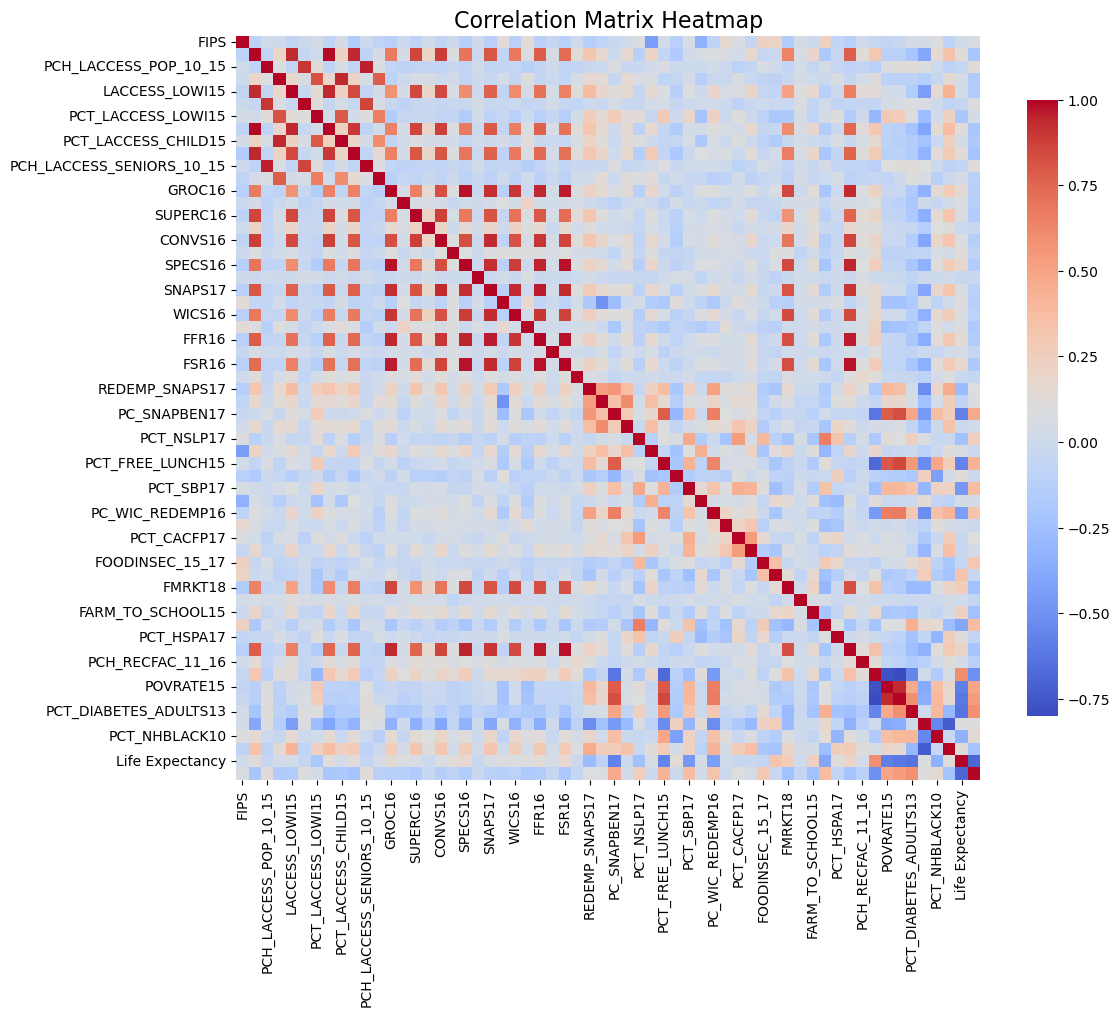

C:\Users\alsae\AppData\Local\Temp\ipykernel_15920\3486400848.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


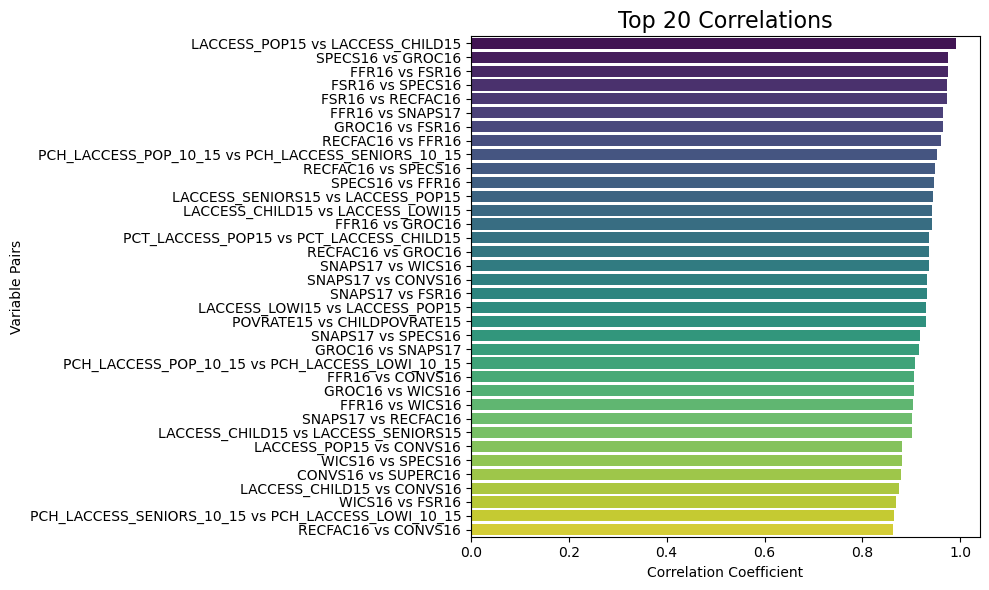

In [17]:
numeric_data = combined_dataset.select_dtypes(include=['float64', 'int64']).dropna()
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    cmap='coolwarm', 
    annot=False,
    fmt=".2f",
    square=True, 
    cbar_kws={'shrink': 0.8}
)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

top_correlations = correlation_matrix.unstack().sort_values(ascending=False)
top_correlations = top_correlations[top_correlations != 1]
top_correlations = top_correlations.drop_duplicates().head(36)

top_corrs_df = top_correlations.reset_index()
top_corrs_df.columns = ['Variable 1', 'Variable 2', 'Correlation']

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Correlation', 
    y=top_corrs_df['Variable 1'] + ' vs ' + top_corrs_df['Variable 2'], 
    data=top_corrs_df,
    palette='viridis'
)
plt.title('Top 20 Correlations', fontsize=16)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variable Pairs')
plt.tight_layout()
plt.show()

#### PCA and feature selection

In [19]:
health_outcome = 'PCT_DIABETES_ADULTS13'

if health_outcome in numeric_data.columns:
    correlated_features = correlation_matrix[health_outcome].abs().sort_values(ascending=False)
    top_correlated_columns = correlated_features.head(36).index.tolist()

scaler = StandardScaler()
standardized_data = scaler.fit_transform(numeric_data[top_correlated_columns])

pca = PCA(n_components=36)
pca_data = pca.fit_transform(standardized_data)

pca_columns = [f'PC{i+1}' for i in range(36)]
reduced_dataset = pd.DataFrame(pca_data, columns=pca_columns)

In [20]:
reduced_dataset=combined_dataset[top_correlated_columns]
reduced_dataset.describe(include='all')

,PCT_DIABETES_ADULTS13,Life Expectancy,CHILDPOVRATE15,HDM,MEDHHINC15,PCT_FREE_LUNCH15,PC_SNAPBEN17,POVRATE15,PCT_OBESE_ADULTS17,PCT_NHBLACK10,...,PCT_REDUCED_LUNCH15,PCH_WICS_11_16,GROC16,PCH_RECFAC_11_16,CONVS16,LACCESS_SENIORS15,FOODINSEC_15_17,LACCESS_LOWI15,PCT_LACCESS_CHILD15,SNAPS17
count,3142.000000,2983.000000,3139.000000,3036.000000,3139.000000,2854.000000,3087.000000,3139.000000,3143.000000,3143.000000,...,2854.000000,2984.000000,3143.000000,3000.000000,3143.00000,3124.000000,3143.000000,3123.000000,3124.000000,3117.000000
mean,11.236123,77.791449,23.238738,358.823781,48611.206117,46.274527,16.166559,16.260975,31.862965,8.748643,...,7.288870,-6.560174,20.807827,1.030283,40.35762,2570.415541,12.833726,5833.959524,5.408435,73.513662
std,2.485537,2.555050,9.364172,82.350826,12351.988288,18.863042,9.111685,6.442319,3.329267,14.421441,...,3.713097,24.693297,90.196535,50.972792,97.01666,6184.202345,2.194020,13989.348252,4.817501,209.590608
min,3.300000,69.716667,3.300000,118.600000,22894.000000,0.000000,0.436994,3.400000,22.600000,0.000000,...,0.000000,-85.714287,0.000000,-100.000000,0.00000,0.000000,7.400000,0.000000,0.000000,0.083333
25%,9.500000,76.004348,16.250000,299.375000,40438.000000,32.976951,9.597230,11.500000,30.100000,0.398882,...,5.091226,-20.000000,2.000000,-10.051020,7.00000,273.978490,11.200000,608.235919,2.410256,10.416667
50%,11.100000,77.770000,22.300000,349.100000,46807.000000,44.185470,14.876845,15.200000,32.400000,1.905529,...,7.302426,0.000000,5.000000,0.000000,15.00000,662.445677,13.000000,1636.858816,4.398577,24.000000
75%,12.900000,79.544510,29.100000,406.825000,54164.000000,56.038391,20.776097,19.700000,33.800000,9.732428,...,9.393252,0.000000,12.000000,9.942748,35.00000,1846.511461,14.000000,4859.016156,6.872020,58.166667
max,23.500000,89.500000,61.600000,790.300000,125900.000000,100.000000,103.595009,47.400000,38.100000,85.438778,...,35.714286,200.000000,2495.000000,600.000000,2199.00000,86014.561483,17.900000,259479.516033,39.135316,6112.833333


In [21]:
eda_reduced_dataset = {
    'shape': reduced_dataset.shape,
    'columns': reduced_dataset.columns.tolist(),
    'data_types': reduced_dataset.dtypes,
    'missing_values': reduced_dataset.isnull().sum(),
    'summary_statistics': reduced_dataset.describe(include='all')
}

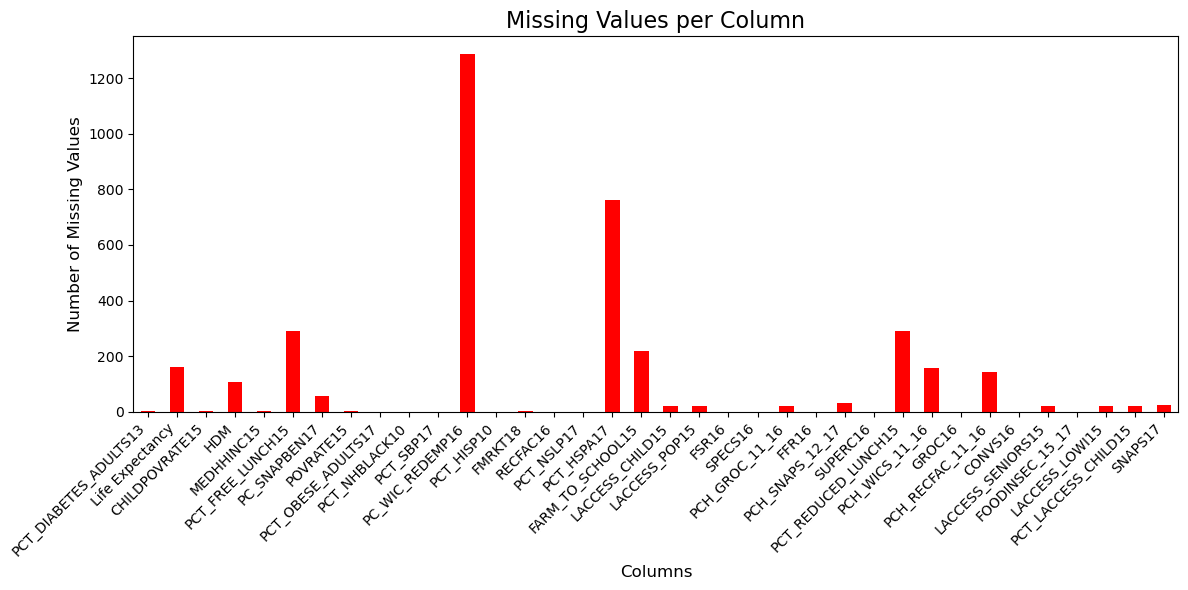

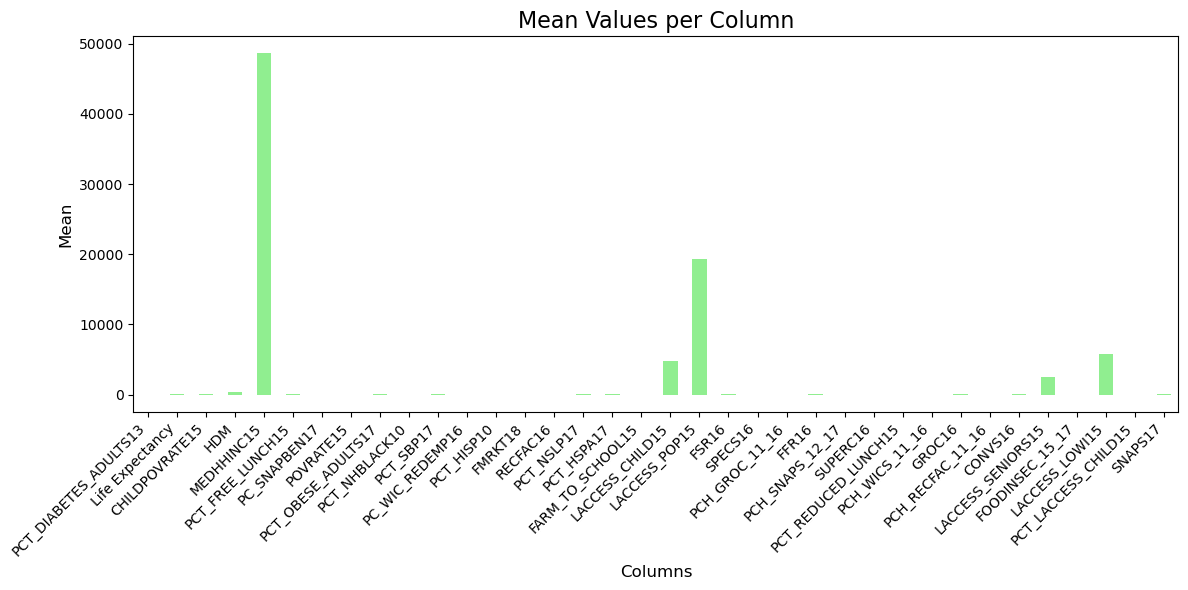

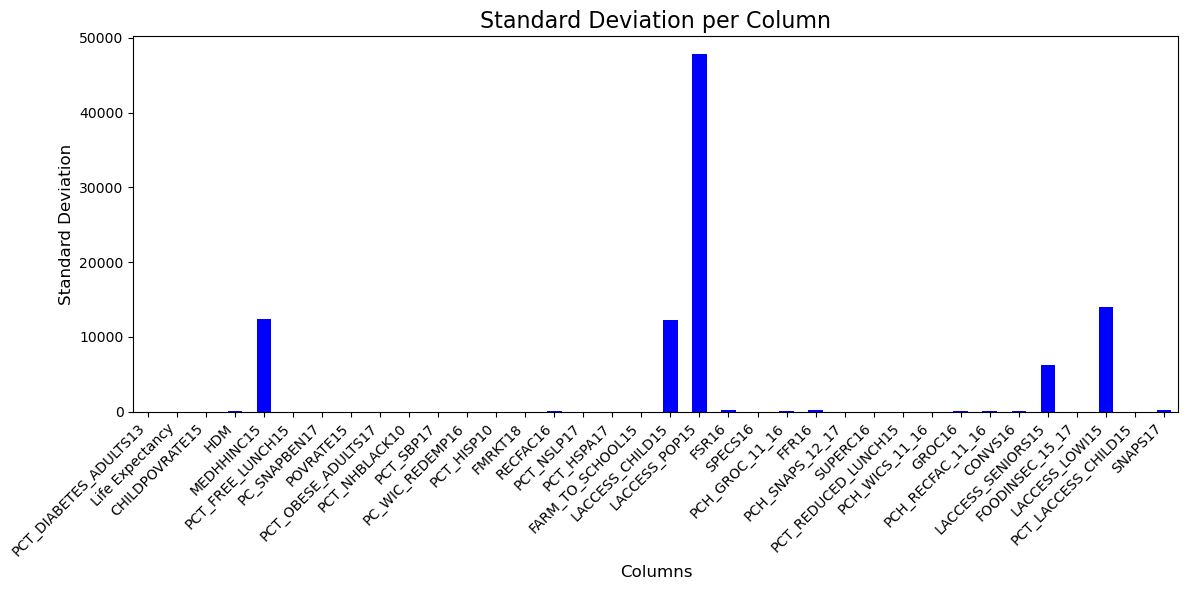

In [22]:
#missing values
plt.figure(figsize=(12, 6))
missing_values = eda_reduced_dataset['missing_values']
missing_values.plot(kind='bar', color='red')
plt.title("Missing Values per Column", fontsize=16)
plt.xlabel("Columns", fontsize=12)
plt.ylabel("Number of Missing Values", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#summary statistics
summary_stats = eda_reduced_dataset['summary_statistics']

#means
plt.figure(figsize=(12, 6))
summary_stats.loc['mean'].plot(kind='bar', color='lightgreen')
plt.title("Mean Values per Column", fontsize=16)
plt.xlabel("Columns", fontsize=12)
plt.ylabel("Mean", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#standard deviations
plt.figure(figsize=(12, 6))
summary_stats.loc['std'].plot(kind='bar', color='blue')
plt.title("Standard Deviation per Column", fontsize=16)
plt.xlabel("Columns", fontsize=12)
plt.ylabel("Standard Deviation", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:
# file_path = 'combined_dataset.xlsx'
# combined_dataset.to_excel(file_path, index=False)

## Objective 2

#### Visualize healthy and unhealthy counties in reduced dimensions. Can we visually differentiate the distributions of healthy and unhealthy counties?


Variable Names

Adult diabetes rate, 2013: PCT_DIABETES_ADULTS13 

Recreation & fitness facilities, 2016: RECFAC16 

Median household income, 2015: MEDHHINC15 

Poverty rate, 2015: POVRATE15 

Child poverty rate, 2015: CHILDPOVRATE15 

Heart Disease Mortality 2013: HDM 

Life Expectancy: Life Expectancy


Method: K-means with reduced dimensions PCA and KDE contours to show distribution of health groups. 

1. Data Normalization: In preparation for K-Means, we used StandardScaler to standardize features by removing the mean and scaling them to unit variance. 

2. K-Means Clustering: We decided on k=2 since Silhouette Score show diminution returns after K=2. We used this model to group counties based on health-related variables into distinct health categories (healthy vs unhealthy). 

3. PCA: We used PCA to reduce the health-related factors into two dimensions (PCA1 and PCA2) for visualization. The two dimensions capture 78% of the original data. 

4. Kernel Density Estimation: We overlaid KED on the PCA plot to illustrate where health groups are most concentrated.

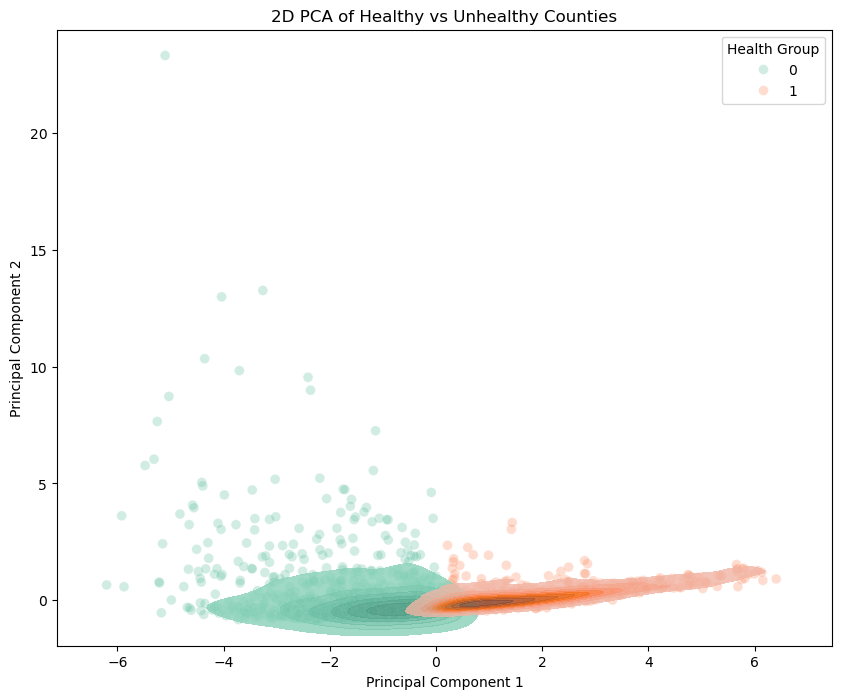

In [25]:
health_factors = ['Life Expectancy', 'MEDHHINC15', 'POVRATE15', 'CHILDPOVRATE15', 'RECFAC16', 'PCT_DIABETES_ADULTS13', 'HDM']
cleaned_data_health = combined_dataset[health_factors].dropna()

scaler = StandardScaler()
normalized_data = scaler.fit_transform(cleaned_data_health.drop(['Life Expectancy', 'HDM'], axis=1))

kmeans = KMeans(n_clusters=2, random_state=42)
cleaned_data_health['Health_Group'] = kmeans.fit_predict(normalized_data)

pca = PCA(n_components=2)
pca_results = pca.fit_transform(normalized_data)
cleaned_data_health['PCA1'] = pca_results[:, 0]
cleaned_data_health['PCA2'] = pca_results[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Health_Group', palette='Set2', data=cleaned_data_health, s=50, alpha=0.3
)
sns.kdeplot(
    x='PCA1', y='PCA2', hue='Health_Group', data=cleaned_data_health, palette='Set2', fill=True, alpha=0.8
)
plt.title("2D PCA of Healthy vs Unhealthy Counties")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Health Group', loc='upper right')
plt.show()

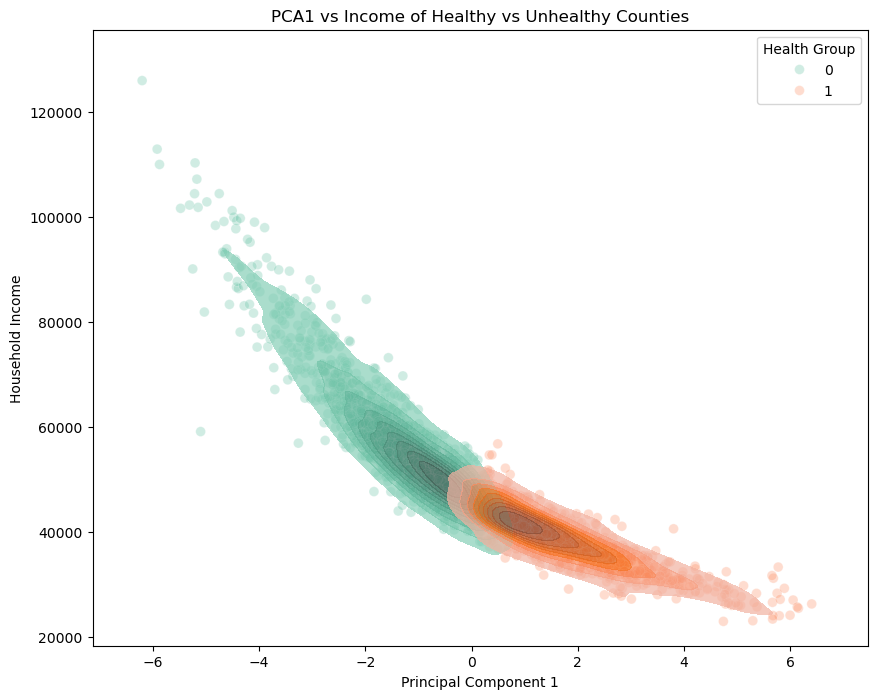

In [26]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y=cleaned_data_health['MEDHHINC15'], hue='Health_Group', palette='Set2', data=cleaned_data_health, s=50, alpha=0.3
)
sns.kdeplot(
    x='PCA1', y=cleaned_data_health['MEDHHINC15'], hue='Health_Group', data=cleaned_data_health, palette='Set2', fill=True, alpha=0.7
)
plt.title("PCA1 vs Income of Healthy vs Unhealthy Counties")
plt.xlabel("Principal Component 1")
plt.ylabel("Household Income")
plt.legend(title='Health Group', loc='upper right')
plt.show()

2D PCA plot shows PCA 2 has less contribution to clustering and PCA1 effectively differentiating counties based on socioeconomic and health factors. PCA1 vs Income plot shows that income has large effect on clustering. 

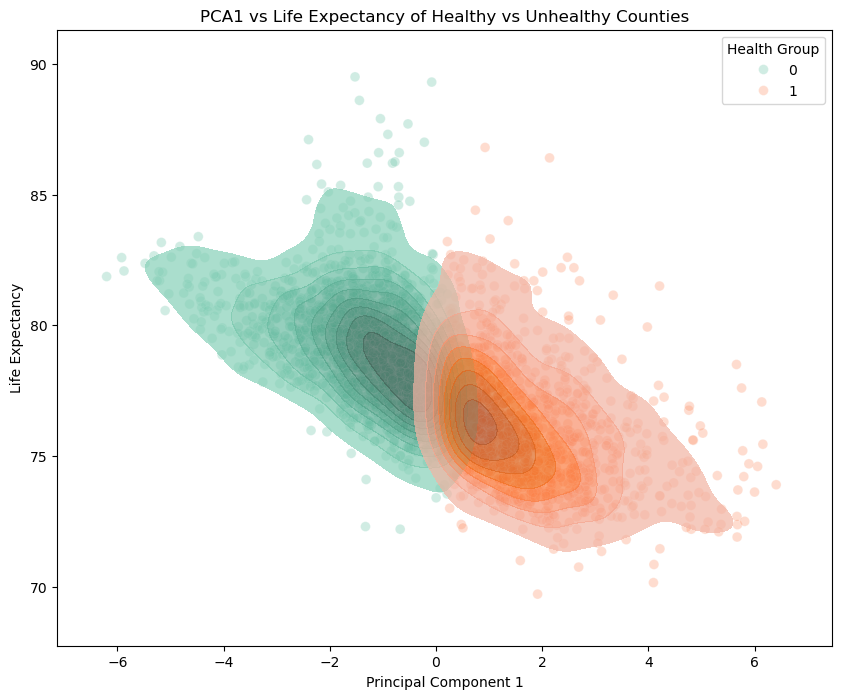

In [28]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y=cleaned_data_health['Life Expectancy'], hue='Health_Group', palette='Set2', data=cleaned_data_health, s=50, alpha=0.3
)
sns.kdeplot(
    x='PCA1', y=cleaned_data_health['Life Expectancy'], hue='Health_Group', data=cleaned_data_health, palette='Set2', fill=True, alpha=0.7
)
plt.title("PCA1 vs Life Expectancy of Healthy vs Unhealthy Counties")
plt.xlabel("Principal Component 1")
plt.ylabel("Life Expectancy")
plt.legend(title='Health Group', loc='upper right')
plt.show()

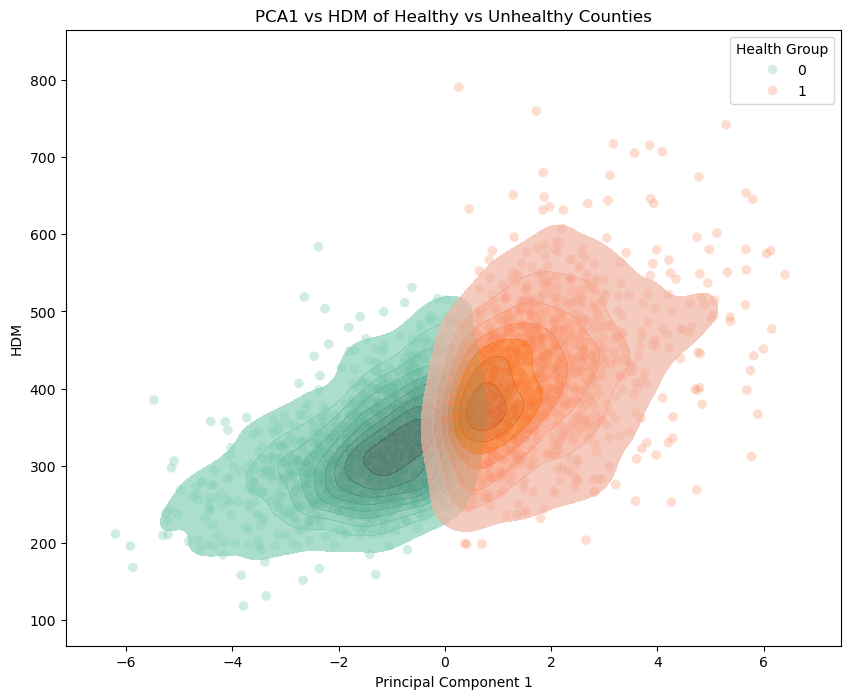

In [29]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y=cleaned_data_health['HDM'], hue='Health_Group', palette='Set2', data=cleaned_data_health, s=50, alpha=0.3
)
sns.kdeplot(
    x='PCA1', y=cleaned_data_health['HDM'], hue='Health_Group', data=cleaned_data_health, palette='Set2', fill=True, alpha=0.7
)
plt.title("PCA1 vs HDM of Healthy vs Unhealthy Counties")
plt.xlabel("Principal Component 1")
plt.ylabel("HDM")
plt.legend(title='Health Group', loc='upper right')
plt.show()

PCA1 vs. HDM and life expectancy plots show clear separation between clusters, particularly for HDM scores and life expectancy, with some overlap in some counties.

In [31]:
cleaned_data_health['Cluster'] = cleaned_data_health['Health_Group']

cluster_analysis = cleaned_data_health.groupby('Cluster')[
    ['Life Expectancy', 'MEDHHINC15', 'POVRATE15', 'CHILDPOVRATE15', 'RECFAC16', 'PCT_DIABETES_ADULTS13', 'HDM']
].mean()

cluster_analysis_sorted = cluster_analysis.sort_values('Life Expectancy')
print(cluster_analysis_sorted)

         Life Expectancy    MEDHHINC15  POVRATE15  CHILDPOVRATE15   RECFAC16  \
Cluster                                                                        
1              76.159216  39127.472629   21.51357       31.427756   3.239013   
0              79.047906  55845.774481   12.08095       16.765875  17.163205   

         PCT_DIABETES_ADULTS13         HDM  
Cluster                                     
1                    12.980802  409.445644  
0                     9.942196  321.615905  


Cluster 0 reflects areas with better socioeconomic and health outcomes. Cluster 0 shows counties with an average life expectancy of 79 years, that is three years more than cluster 1 at 76 years. The median income for cluster 0 is 55K, that is 16K more than cluster 1 at $39K. Cluster 0 includes counties with an average child poverty rate of %16.7 vs %31.4 in cluster 1. Cluster 0 has significantly more recreational facilities and a lower percentage of adults with diabetes/HDM than cluster 1. Cluster 1 represents areas with poorer outcomes, facing higher poverty, limited facilities, and greater health risks. 

In [33]:
# file_path = 'combined_dataset.xlsx'
# cluster_analysis_sorted.to_excel(file_path, index=False)

In [34]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(normalized_data, kmeans.labels_)

explained_variance_ratio = pca.explained_variance_ratio_

cluster_sizes = cleaned_data_health['Health_Group'].value_counts()

print("Clustering Performance Metrics:")
print(f"Silhouette Score: {silhouette_avg:.2f}")
print("\nCluster Sizes:")
print(cluster_sizes)

print("\nPCA Performance Metrics:")
print(f"Explained Variance Ratio (PCA1): {explained_variance_ratio[0]:.2f}")
print(f"Explained Variance Ratio (PCA2): {explained_variance_ratio[1]:.2f}")

Clustering Performance Metrics:
Silhouette Score: 0.39

Cluster Sizes:
Health_Group
0    1685
1    1297
Name: count, dtype: int64

PCA Performance Metrics:
Explained Variance Ratio (PCA1): 0.65
Explained Variance Ratio (PCA2): 0.20


Silhouette Score shows how similar a point is to its own cluster compared to others. A score closer to 1 is ideal and a score closer to 0 considered poor. K-means clustering performance is showing 0.39, which is reasonable for this data as we expect some overlap in health outcomes for some counties. Cluster 0 contains 1,670 counties vs cluster 1 includes 1,310 counties. PCA performance shows PCA1 explaining %65 of the variance in the data and PCA2 explains another %20. 

In [36]:
# from sklearn.metrics import silhouette_score
# import numpy as np

# silhouette_scores = {}
# for n_clusters in range(2, 7):
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     labels = kmeans.fit_predict(normalized_data)
#     score = silhouette_score(normalized_data, labels)
#     silhouette_scores[n_clusters] = score

# for n_clusters, score in silhouette_scores.items():
#     print(f"Number of clusters: {n_clusters}, Silhouette Score: {score:.2f}")

In [37]:
pca_full = PCA(n_components=3)
pca_results_full = pca_full.fit_transform(normalized_data)

explained_variance_full = pca_full.explained_variance_ratio_
for i, ratio in enumerate(explained_variance_full):
    print(f"PCA Component {i+1} Explained Variance: {ratio:.2f}")

PCA Component 1 Explained Variance: 0.65
PCA Component 2 Explained Variance: 0.20
PCA Component 3 Explained Variance: 0.11


PCA components results diminish after PCA3

In [39]:
#3D Visualization using first three PCA components
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(
#     pca_results_full[:, 0], pca_results_full[:, 1], pca_results_full[:, 2],
#     c=cleaned_data_health['Health_Group'], cmap='Set2', alpha=0.8
# )
# ax.set_title("3D PCA Clusters")
# ax.set_xlabel("PCA1")
# ax.set_ylabel("PCA2")
# ax.set_zlabel("PCA3")
# plt.colorbar(scatter, ax=ax, label='Cluster')
# plt.show()

In [40]:
cleaned_data_with_clusters = combined_dataset.loc[combined_dataset['Life Expectancy'].notnull() & combined_dataset['MEDHHINC15'].notnull()].copy()
cleaned_data_with_clusters['Health_Group'] = kmeans.predict(normalized_data)
cleaned_data_with_clusters['Health_Group'] = cleaned_data_with_clusters['Health_Group'].replace({1: 'Unhealthy', 2: 'Average', 0: 'Healthy'})

top_healthy = cleaned_data_with_clusters.sort_values('Life Expectancy', ascending=False).head(5)
top_unhealthy = cleaned_data_with_clusters.sort_values('Life Expectancy', ascending=True).head(5)

print("Top 5 Healthiest Counties:")
print(top_healthy[['County', 'State', 'Life Expectancy', 'HDM', 'Health_Group']])

print("\nTop 5 Least Healthy Counties:")
print(top_unhealthy[['County', 'State', 'Life Expectancy', 'HDM', 'Health_Group']])

Top 5 Healthiest Counties:
            County State  Life Expectancy    HDM Health_Group
253   Cheyenne, CO    CO             89.5  241.9      Healthy
2804     Wayne, UT    UT             89.3  284.6      Healthy
928    Haskell, KS    KS             88.6  289.2      Healthy
981    Stanton, KS    KS             87.9  196.7      Healthy
569     Custer, ID    ID             87.7  267.4      Healthy

Top 5 Least Healthy Counties:
                County State  Life Expectancy    HDM Health_Group
2176      McIntosh, OK    OK        69.716667  500.2    Unhealthy
1005     Breathitt, KY    KY        70.157143  706.9    Unhealthy
1091        Powell, KY    KY        70.750000  536.2    Unhealthy
1468  Tallahatchie, MS    MS        70.850000  477.2    Unhealthy
2907        Sussex, VA    VA        71.000000  403.9    Unhealthy


#### Validation - Objective 2

In [42]:
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from statsmodels.formula.api import ols
import numpy as np

health_factors = ['MEDHHINC15', 'POVRATE15', 'CHILDPOVRATE15', 'RECFAC16', 'PCT_DIABETES_ADULTS13']

train_data, test_data = train_test_split(normalized_data, test_size=0.3, random_state=42)

kmeans_train = KMeans(n_clusters=2, random_state=42).fit(train_data)
train_labels = kmeans_train.labels_

test_labels = kmeans_train.predict(test_data)

silhouette_train = silhouette_score(train_data, train_labels)
silhouette_test = silhouette_score(test_data, test_labels)

cleaned_data_health['Cluster_Label'] = kmeans.labels_


# anova_results_sm = {}
# for factor in health_factors:
#     model = ols(f"{factor} ~ C(Cluster_Label)", data=cleaned_data_health).fit()
#     anova_table = sm.stats.anova_lm(model, typ=2)
#     anova_results_sm[factor] = {
#         "F-statistic": anova_table["F"][0],
#         "p-value": anova_table["PR(>F)"][0]
#     }

# anova_results_df = pd.DataFrame(anova_results_sm).T

# print("ANOVA Results for Health Groups:")
# print(anova_results_df)


cleaned_data_health['PCA1_Z'] = stats.zscore(cleaned_data_health['PCA1'])
cleaned_data_health['PCA2_Z'] = stats.zscore(cleaned_data_health['PCA2'])

outliers = cleaned_data_health[(np.abs(cleaned_data_health['PCA1_Z']) > 3) | (np.abs(cleaned_data_health['PCA2_Z']) > 3)]

print("\nCross-Validation Results:")
print(f"Silhouette Score (Train): {silhouette_train}")
print(f"Silhouette Score (Test): {silhouette_test}")

print("\nOutlier Detection:")
print(f"Number of Outliers: {len(outliers)}")
print(outliers[['PCA1', 'PCA2', 'PCA1_Z', 'PCA2_Z']])


Cross-Validation Results:
Silhouette Score (Train): 0.39433230012968945
Silhouette Score (Test): 0.36766275565093126

Outlier Detection:
Number of Outliers: 69
          PCA1      PCA2    PCA1_Z    PCA2_Z
5     5.753605  0.885230  3.200898  0.895510
31    6.154520  0.844688  3.423939  0.854497
42    5.684104  0.575841  3.162233  0.582528
52    6.405215  0.909970  3.563408  0.920537
103  -2.362721  8.991367 -1.314451  9.095783
...        ...       ...       ...       ...
2742 -1.794717  3.753576 -0.998454  3.797166
2749 -3.028867  5.176141 -1.685047  5.236251
2848 -5.918832  3.612269 -3.292819  3.654218
2872 -6.201960  0.650298 -3.450331  0.657850
2970 -5.030374  8.725670 -2.798544  8.827000

[69 rows x 4 columns]


In [43]:
#outliers

In [44]:
# filtered_data = cleaned_data_health[(np.abs(cleaned_data_health['PCA1_Z']) <= 3) & (np.abs(cleaned_data_health['PCA2_Z']) <= 3)]

# cleaned_normalized_data = normalized_data[(np.abs(cleaned_data_health['PCA1_Z']) <= 3) & (np.abs(cleaned_data_health['PCA2_Z']) <= 3)]

# kmeans_cleaned = KMeans(n_clusters=2, random_state=42).fit(cleaned_normalized_data)
# filtered_data['Cluster_Label'] = kmeans_cleaned.labels_

# centroids_corrected = []
# for cluster in np.unique(kmeans_cleaned.labels_):
#     cluster_points = filtered_data[filtered_data['Cluster_Label'] == cluster][['PCA1', 'PCA2']].values
#     centroid = cluster_points.mean(axis=0) 
#     centroids_corrected.append(centroid)
# centroids_corrected = np.array(centroids_corrected)

# plt.figure(figsize=(10, 8))
# sns.scatterplot(
#     x='PCA1', y='PCA2', hue='Health_Group', palette='Set2', data=filtered_data, s=50, alpha=0.3
# )
# sns.kdeplot(
#     x='PCA1', y='PCA2', hue='Health_Group', data=filtered_data, palette='Set2', fill=True, alpha=0.8
# )
# plt.title("2D PCA of Healthy vs Unhealthy Counties")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.legend(title='Health Group', loc='upper right')
# plt.show()

# silhouette_cleaned = silhouette_score(cleaned_normalized_data, kmeans_cleaned.labels_)

# # print(f"Silhouette Score After Removing Outliers: {silhouette_cleaned:.4f}")

In [45]:
# plt.figure(figsize=(10, 8))
# sns.scatterplot(
#     x='PCA1', y=filtered_data['Life Expectancy'], hue='Health_Group', palette='Set2', data=filtered_data, s=50, alpha=0.3
# )
# sns.kdeplot(
#     x='PCA1', y=filtered_data['Life Expectancy'], hue='Health_Group', data=filtered_data, palette='Set2', fill=True, alpha=0.7
# )
# plt.title("PCA1 vs Life Expectancy of Healthy vs Unhealthy Counties")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Life Expectancy")
# plt.legend(title='Health Group', loc='upper right')
# plt.show()

In [46]:
# from sklearn.metrics import pairwise_distances
# import numpy as np

# pca_values = cleaned_data_health[['PCA1', 'PCA2']].values
# cluster_labels = cleaned_data_health['Cluster_Label'].values

# centroids = []
# for cluster in np.unique(cluster_labels):
#     centroid = pca_values[cluster_labels == cluster].mean(axis=0)
#     centroids.append(centroid)
# centroids = np.array(centroids)

# inter_cluster_distances = pairwise_distances(centroids)

# intra_cluster_variance = {}
# for cluster in np.unique(cluster_labels):
#     cluster_points = pca_values[cluster_labels == cluster]
#     centroid = centroids[cluster]
#     variance = np.mean(np.linalg.norm(cluster_points - centroid, axis=1))
#     intra_cluster_variance[cluster] = variance

# print("Inter-Cluster Distances (between centroids):")
# print(inter_cluster_distances)

# print("\nIntra-Cluster Variance (average distance to centroid):")
# for cluster, variance in intra_cluster_variance.items():
#     print(f"Cluster {cluster}: {variance:.4f}")

# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 8))
# for cluster in np.unique(cluster_labels):
#     cluster_points = pca_values[cluster_labels == cluster]
#     plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", alpha=0.6)
#     plt.scatter(
#         centroids[cluster, 0], centroids[cluster, 1], color='black', marker='x', s=100, label=f"Centroid {cluster}"
#     )

# plt.title("Cluster Separation in PCA Space")
# plt.xlabel("PCA1")
# plt.ylabel("PCA2")
# plt.legend()
# plt.grid()
# plt.show()

#### Objective 3

In [48]:
import statsmodels.api as sm
import seaborn as sns

Obj3 = cleaned_data_with_clusters[['State', 'County', 'Life Expectancy', 'PCT_NHWHITE10', 'PCT_NHBLACK10', 'MEDHHINC15', 'POVRATE15', 'CHILDPOVRATE15', 'RECFAC16', 'PCT_DIABETES_ADULTS13', 'Health_Group']].dropna()
def demographic_group(row):
    if row['PCT_NHWHITE10'] > 75:
        return '>75% White'
    elif 50 <= row['PCT_NHWHITE10'] <= 74:
        return '50-74% White'
    else:
        return '<50% White'

Obj3['Demographic_Group'] = Obj3.apply(demographic_group, axis=1)

X_combined = Obj3[['MEDHHINC15']]
X_combined = sm.add_constant(X_combined)
Y_combined = Obj3['Life Expectancy']

model_Obj3 = sm.OLS(Y_combined, X_combined).fit()

print(model_Obj3.summary())

                            OLS Regression Results                            
Dep. Variable:        Life Expectancy   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     1240.
Date:                Sat, 30 Nov 2024   Prob (F-statistic):          2.12e-227
Time:                        13:09:59   Log-Likelihood:                -6509.9
No. Observations:                2982   AIC:                         1.302e+04
Df Residuals:                    2980   BIC:                         1.304e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.3006      0.161    449.558      0.0

In [49]:
X_combined_full = combined_dataset[['Life Expectancy', 'LACCESS_POP15', 'PCH_LACCESS_POP_10_15','PCT_LACCESS_POP15','LACCESS_LOWI15','PCH_LACCESS_LOWI_10_15','PCT_LACCESS_LOWI15',
'LACCESS_CHILD15','PCT_LACCESS_CHILD15','LACCESS_SENIORS15','PCH_LACCESS_SENIORS_10_15','PCT_LACCESS_SENIORS15',
'GROC16','PCH_GROC_11_16','SUPERC16','PCH_SUPERC_11_16','CONVS16','PCH_CONVS_11_16','SPECS16','PCH_SPECS_11_16','SNAPS17','PCH_SNAPS_12_17',
'WICS16','PCH_WICS_11_16','FFR16','PCH_FFR_11_16','FSR16','PCH_FSR_11_16','REDEMP_SNAPS17','PCH_REDEMP_SNAPS_12_17','PC_SNAPBEN17',
'PCH_PC_SNAPBEN_12_17','PCT_NSLP17','PCH_NSLP_12_17','PCT_FREE_LUNCH15','PCT_REDUCED_LUNCH15','PCT_SBP17','PCH_SBP_12_17','PC_WIC_REDEMP16',
'PCH_PC_WIC_REDEMP_11_16','PCT_CACFP17','PCH_CACFP_12_17','FOODINSEC_15_17','CH_FOODINSEC_14_17','FMRKT18','PCH_FMRKT_13_18',
'FARM_TO_SCHOOL15','PCT_OBESE_ADULTS17','PCT_HSPA17','RECFAC16','PCH_RECFAC_11_16','MEDHHINC15','POVRATE15','CHILDPOVRATE15', 'PCT_DIABETES_ADULTS13', 'PCT_NHWHITE10', 'PCT_NHBLACK10', 'PCT_HISP10']].copy()
X_combined_full = X_combined_full.dropna()
Y_combined = X_combined_full['Life Expectancy']
X_combined_full = X_combined_full.drop('Life Expectancy', axis=1)
X_combined_full = sm.add_constant(X_combined_full)


model_Obj3_full = sm.OLS(Y_combined, X_combined_full).fit()

print(model_Obj3_full.summary())

                            OLS Regression Results                            
Dep. Variable:        Life Expectancy   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     37.22
Date:                Sat, 30 Nov 2024   Prob (F-statistic):          2.85e-192
Time:                        13:10:00   Log-Likelihood:                -1424.4
No. Observations:                 912   AIC:                             2965.
Df Residuals:                     854   BIC:                             3244.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

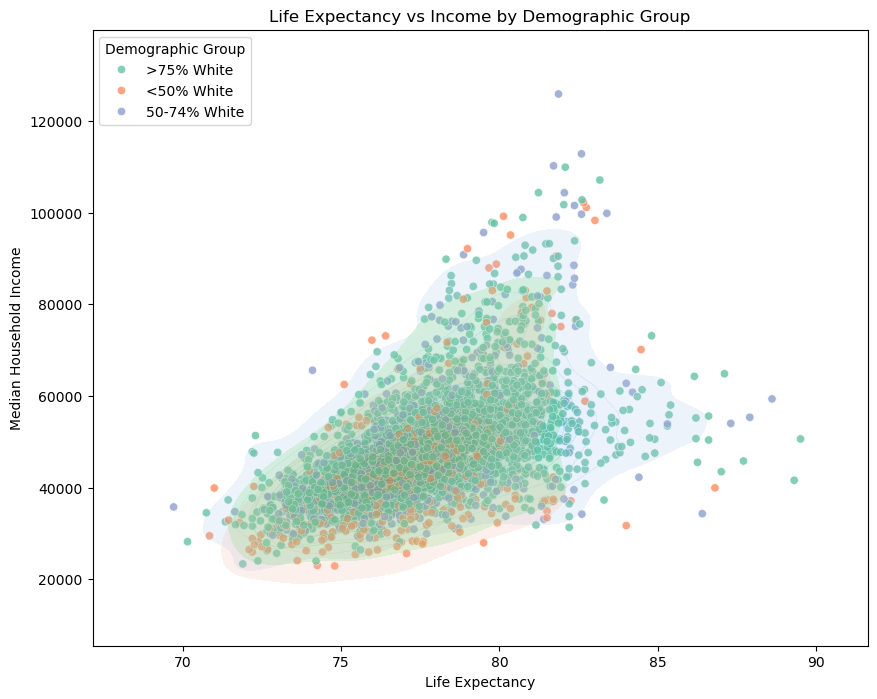

In [50]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=Obj3,
    x='Life Expectancy',
    y='MEDHHINC15',
    hue='Demographic_Group',
    palette='Set2',
    alpha=0.8
)
sns.kdeplot(
    data=Obj3,
    x='Life Expectancy',
    y='MEDHHINC15',
    hue='Demographic_Group',
    fill=True,
    alpha=0.2
)
plt.title("Life Expectancy vs Income by Demographic Group")
plt.xlabel("Life Expectancy")
plt.ylabel("Median Household Income")
plt.legend(title='Demographic Group', loc='upper left')
plt.show()

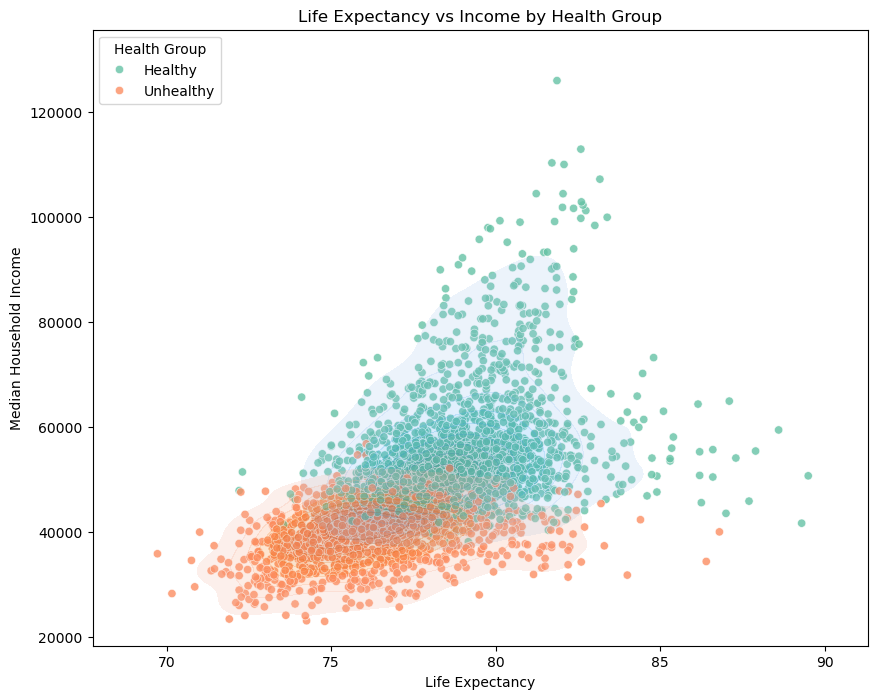

In [51]:
#kmeans = KMeans(n_clusters=3, random_state=42)
#cleaned_data_with_clusters['Health_Group'] = kmeans.fit_predict(normalized_data)
#cleaned_data_with_clusters['Health_Group'] = cleaned_data_with_clusters['Health_Group'].replace({1: 'Unhealthy', 2: 'Semi-healthy', 0: 'Healthy'})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=Obj3,
    x='Life Expectancy',
    y='MEDHHINC15',
    hue='Health_Group',
    palette='Set2',
    alpha=0.8
)
sns.kdeplot(
    data=Obj3,
    x='Life Expectancy',
    y='MEDHHINC15',
    hue='Health_Group',
    fill=True,
    alpha=0.2
)
plt.title("Life Expectancy vs Income by Health Group")
plt.xlabel("Life Expectancy")
plt.ylabel("Median Household Income")
plt.legend(title='Health Group', loc='upper left')
plt.show()

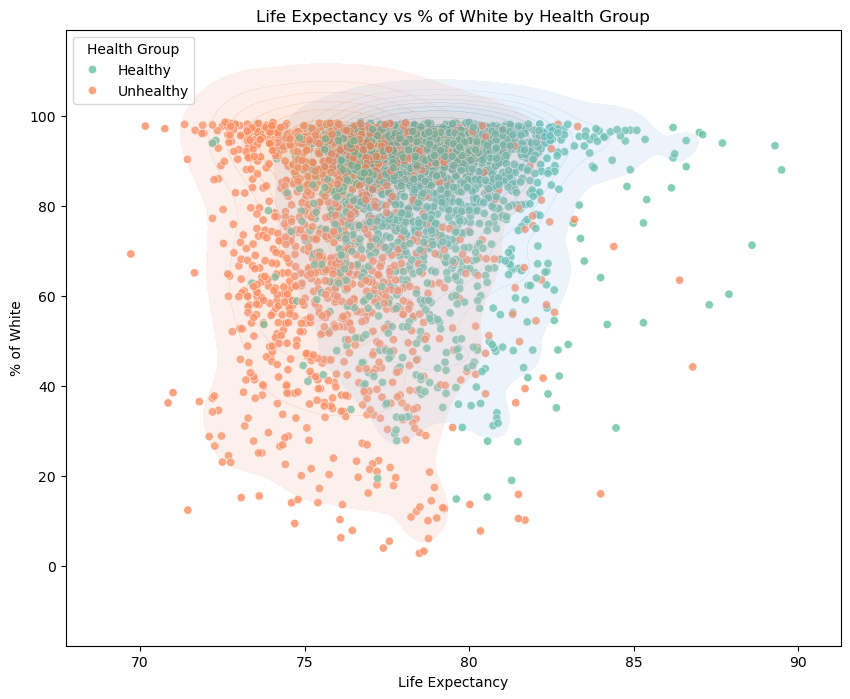

In [52]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=Obj3,
    x='Life Expectancy',
    y='PCT_NHWHITE10',
    hue='Health_Group',
    palette='Set2',
    alpha=0.8
)
sns.kdeplot(
    data=Obj3,
    x='Life Expectancy',
    y='PCT_NHWHITE10',
    hue='Health_Group',
    fill=True,
    alpha=0.2
)
plt.title("Life Expectancy vs % of White by Health Group")
plt.xlabel("Life Expectancy")
plt.ylabel("% of White")
plt.legend(title='Health Group', loc='upper left')
plt.show()